In [9]:
import numpy as np
import dask.dataframe as dd
import pandas as pd

# import modin.pandas as pd
from pathlib import Path
from sklearn.metrics import mean_absolute_error
from datetime import timedelta
from functools import reduce
from tqdm import tqdm
# import lightgbm as lgbm
# import mlb
import matplotlib.pyplot as plt
import os

import gc

In [2]:
config = {
    'directory': r'C:\Users\avish\Documents\github_projects\MLB_Player_Digital_Engagement\mlb-player-digital-engagement-forecasting',
}

In [ ]:
!pip install dask

In [3]:
!pip install cloudpickle==1.5.0

In [ ]:
!python -m pip install "dask[complete]"

In [ ]:
!python -m pip install "dask[array]"

In [10]:
train = pd.read_csv(os.path.join(config['directory'], 'train.csv'))

train

,date,nextDayPlayerEngagement,games,rosters,playerBoxScores,teamBoxScores,transactions,standings,awards,events,playerTwitterFollowers,teamTwitterFollowers
0,20180101,"[{""engagementMetricsDate"":""2018-01-02"",""player...",NaN,"[{""playerId"":400121,""gameDate"":""2018-01-01"",""t...",NaN,NaN,"[{""transactionId"":340732,""playerId"":547348,""pl...",NaN,NaN,NaN,"[{""date"":""2018-01-01"",""playerId"":545361,""playe...","[{""date"":""2018-01-01"",""teamId"":147,""teamName"":..."
1,20180102,"[{""engagementMetricsDate"":""2018-01-03"",""player...",NaN,"[{""playerId"":134181,""gameDate"":""2018-01-02"",""t...",NaN,NaN,"[{""transactionId"":339458,""playerId"":621173,""pl...",NaN,NaN,NaN,NaN,NaN
2,20180103,"[{""engagementMetricsDate"":""2018-01-04"",""player...",NaN,"[{""playerId"":425492,""gameDate"":""2018-01-03"",""t...",NaN,NaN,"[{""transactionId"":347527,""playerId"":572389,""pl...",NaN,NaN,NaN,NaN,NaN
3,20180104,"[{""engagementMetricsDate"":""2018-01-05"",""player...",NaN,"[{""playerId"":282332,""gameDate"":""2018-01-04"",""t...",NaN,NaN,"[{""transactionId"":339549,""playerId"":545343,""pl...",NaN,NaN,NaN,NaN,NaN
4,20180105,"[{""engagementMetricsDate"":""2018-01-06"",""player...",NaN,"[{""playerId"":282332,""gameDate"":""2018-01-05"",""t...",NaN,NaN,"[{""transactionId"":341195,""playerId"":628336,""pl...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1211,20210426,"[{""engagementMetricsDate"":""2021-04-27"",""player...","[{""gamePk"":634374,""gameType"":""R"",""season"":2021...","[{""playerId"":405395,""gameDate"":""2021-04-26"",""t...","[{""home"":1,""gamePk"":634377,""gameDate"":""2021-04...","[{""home"":1,""teamId"":139,""gamePk"":634343,""gameD...","[{""transactionId"":480386,""playerId"":543685,""pl...","[{""season"":2021,""gameDate"":""2021-04-26"",""divis...",NaN,"[{""gamePk"":634433,""gameDate"":""2021-04-26"",""gam...",NaN,NaN
1212,20210427,"[{""engagementMetricsDate"":""2021-04-28"",""player...","[{""gamePk"":634318,""gameType"":""R"",""season"":2021...","[{""playerId"":443558,""gameDate"":""2021-04-27"",""t...","[{""home"":1,""gamePk"":634320,""gameDate"":""2021-04...","[{""home"":1,""teamId"":117,""gamePk"":634333,""gameD...","[{""transactionId"":480456,""playerId"":642162,""pl...","[{""season"":2021,""gameDate"":""2021-04-27"",""divis...",NaN,"[{""gamePk"":634332,""gameDate"":""2021-04-27"",""gam...",NaN,NaN
1213,20210428,"[{""engagementMetricsDate"":""2021-04-29"",""player...","[{""gamePk"":634309,""gameType"":""R"",""season"":2021...","[{""playerId"":429722,""gameDate"":""2021-04-28"",""t...","[{""home"":1,""gamePk"":634310,""gameDate"":""2021-04...","[{""home"":0,""teamId"":111,""gamePk"":634310,""gameD...","[{""transactionId"":480728,""playerId"":545358,""pl...","[{""season"":2021,""gameDate"":""2021-04-28"",""divis...",NaN,"[{""gamePk"":634317,""gameDate"":""2021-04-28"",""gam...",NaN,NaN
1214,20210429,"[{""engagementMetricsDate"":""2021-04-30"",""player...","[{""gamePk"":634330,""gameType"":""R"",""season"":2021...","[{""playerId"":405395,""gameDate"":""2021-04-29"",""t...","[{""home"":1,""gamePk"":634330,""gameDate"":""2021-04...","[{""home"":0,""teamId"":119,""gamePk"":634346,""gameD...","[{""transactionId"":480993,""playerId"":606965,""pl...","[{""season"":2021,""gameDate"":""2021-04-29"",""divis...",NaN,"[{""gamePk"":634346,""gameDate"":""2021-04-29"",""gam...",NaN,NaN


In [11]:
# train = pd.read_csv(os.path.join(config['directory'], train.csv))

null = np.nan
true = True
false = False

for col in tqdm(train.columns):

    if col == 'date': continue

    _index = train[col].notnull()
    train.loc[_index, col] = train.loc[_index, col].apply(lambda x: eval(x))

    outputs = []
    for index, date, record in train.loc[_index, ['date', col]].itertuples():
        _df = pd.DataFrame(record)
        _df['index'] = index
        _df['date'] = date
        outputs.append(_df)

    outputs = pd.concat(outputs).reset_index(drop=True)

    outputs.to_csv(f'{col}_train.csv', index=False)

    del outputs
    del train[col]
    gc.collect()

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [13:12<00:00, 66.06s/it]


In [12]:
players = pd.read_csv(os.path.join(config['directory'],'players.csv'))

rosters = pd.read_csv('rosters_train.csv')
targets = pd.read_csv('nextDayPlayerEngagement_train.csv')
followers = pd.read_csv('playerTwitterFollowers_train.csv')
team_followers = pd.read_csv('teamTwitterFollowers_train.csv')
team_followers = team_followers.rename(columns={'numberOfFollowers': 'teamFollowers'})
scores = pd.read_csv('playerBoxScores_train.csv')

In [16]:
import seaborn as sns
import numpy as np

In [14]:
rosters

,playerId,gameDate,teamId,statusCode,status,index,date
0,400121,2018-01-01,116,A,Active,0,20180101
1,408045,2018-01-01,142,A,Active,0,20180101
2,425492,2018-01-01,120,A,Active,0,20180101
3,429664,2018-01-01,136,A,Active,0,20180101
4,431151,2018-01-01,121,A,Active,0,20180101
...,...,...,...,...,...,...,...
1489655,676969,2021-04-30,140,A,Active,1215,20210430
1489656,677960,2021-04-30,135,A,Active,1215,20210430
1489657,680692,2021-04-30,145,RM,Reassigned to Minors,1215,20210430
1489658,680702,2021-04-30,136,RM,Reassigned to Minors,1215,20210430


In [19]:
x = rosters['statusCode'].index

y = rosters['statusCode'].values

print(x)

print('-'*10)

print(y)

RangeIndex(start=0, stop=1489660, step=1)
----------
['A' 'A' 'A' ... 'RM' 'RM' 'A']


c:\users\avish\.conda\envs\phase3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

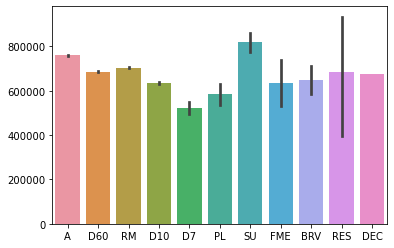

In [22]:
sns.barplot(y,x)

In [33]:
player_target_stats = pd.read_csv('player_target_stats.csv')

player_target_stats.head()

,playerId,target1_mean,target1_median,target1_std,target1_min,target1_max,target1_prob,target2_mean,target2_median,target2_std,...,target3_std,target3_min,target3_max,target3_prob,target4_mean,target4_median,target4_std,target4_min,target4_max,target4_prob
0,502210.0,0.035863,0.009661,0.099927,0.003972,0.526284,0.003972,0.821247,0.552905,0.668016,...,1.158441,0.000958,6.438573,0.004132,6.235656,3.598226,6.748910,1.275168,26.192647,26.192647
1,630105.0,1.904828,0.413371,4.730502,0.003946,25.603476,2.889937,7.176114,6.098486,4.167832,...,0.907514,0.001916,3.357538,0.023800,3.281690,2.440308,3.555386,0.541118,19.266433,1.453019
2,621532.0,0.152532,0.001025,0.484371,0.000128,2.460910,0.003597,0.875908,0.522862,1.095245,...,0.000662,0.000000,0.002905,0.000000,0.303933,0.193071,0.248819,0.026183,0.911599,0.597569
3,468504.0,0.047498,0.000980,0.239338,0.000115,1.335765,0.001515,1.168458,0.658345,1.184460,...,0.176138,0.000000,0.986705,0.006010,0.891975,0.512437,1.253801,0.113460,7.059931,1.527897
4,657108.0,0.893797,0.042066,1.914782,0.004996,7.304291,0.667739,3.632337,2.505707,2.874485,...,2.050363,0.025459,6.629584,6.189074,1.418947,1.206433,1.096405,0.165827,4.739336,0.386319


In [32]:
targets.head()

,engagementMetricsDate,playerId,target1,target2,target3,target4,index,date
0,2018-01-02,628317,0.011167,4.474708,0.005168,5.735294,0,20180101
1,2018-01-02,547989,0.042993,5.593385,0.045033,2.794118,0,20180101
2,2018-01-02,519317,0.974327,56.177043,13.693746,64.166667,0,20180101
3,2018-01-02,607625,0.006700,2.675097,0.005168,1.862745,0,20180101
4,2018-01-02,592547,0.001117,0.632296,0.002953,0.931373,0,20180101


In [31]:
targets_agg =targets.groupby('playerId')[['target1', 'target2', 'target3', 'target4']].agg('median').reset_index()

targets_agg.head()

,playerId,target1,target2,target3,target4
0,112526,0.040627,1.712447,0.117506,10.565405
1,134181,0.073183,1.083241,0.150194,4.698507
2,279571,0.000000,0.090526,0.000000,0.170867
3,282332,0.162304,3.388073,0.313201,8.063467
4,400085,0.077181,2.055594,0.188413,15.306824


In [28]:
player_target_stats_for_corr = pd.merge(player_target_stats, targets_agg, on = ['playerId'], how = 'left')

In [30]:
player_target_stats_for_corr.head()

,playerId,target1_mean,target1_median,target1_std,target1_min,target1_max,target1_prob,target2_mean,target2_median,target2_std,...,target4_mean,target4_median,target4_std,target4_min,target4_max,target4_prob,target1,target2,target3,target4
0,502210.0,0.035863,0.009661,0.099927,0.003972,0.526284,0.003972,0.821247,0.552905,0.668016,...,6.235656,3.598226,6.748910,1.275168,26.192647,26.192647,0.086754,2.949732,0.059882,2.014222
1,630105.0,1.904828,0.413371,4.730502,0.003946,25.603476,2.889937,7.176114,6.098486,4.167832,...,3.281690,2.440308,3.555386,0.541118,19.266433,1.453019,0.000000,0.215544,0.000000,0.017316
2,621532.0,0.152532,0.001025,0.484371,0.000128,2.460910,0.003597,0.875908,0.522862,1.095245,...,0.303933,0.193071,0.248819,0.026183,0.911599,0.597569,0.000612,0.446591,0.000000,0.040556
3,468504.0,0.047498,0.000980,0.239338,0.000115,1.335765,0.001515,1.168458,0.658345,1.184460,...,0.891975,0.512437,1.253801,0.113460,7.059931,1.527897,0.009411,1.776679,0.027517,0.423515
4,657108.0,0.893797,0.042066,1.914782,0.004996,7.304291,0.667739,3.632337,2.505707,2.874485,...,1.418947,1.206433,1.096405,0.165827,4.739336,0.386319,0.001711,0.271297,0.001267,0.269907


In [34]:
corrrelation = player_target_stats_for_corr.drop(columns =['playerId']).corr()

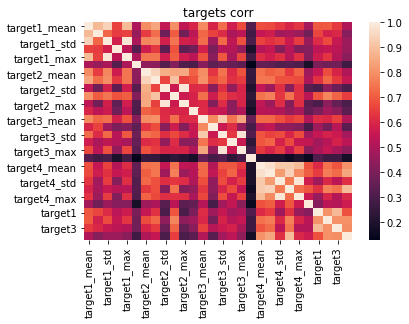

In [35]:
sns.heatmap(corrrelation
       )
plt.title('targets corr')
plt.show()

<AxesSubplot:>

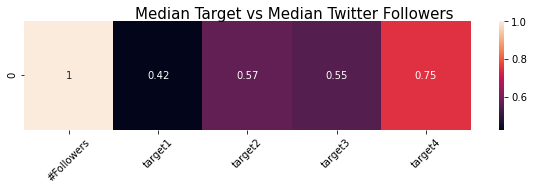

In [38]:
followers_agg =followers.groupby('playerId')['numberOfFollowers'].agg('median').reset_index()

targets_agg =targets.groupby('playerId')[['target1', 'target2', 'target3', 'target4']].agg('median').reset_index()

followers_agg.columns = ['playerId', '#Followers']
followers_agg = pd.merge(followers_agg, targets_agg, on = ['playerId'], how = 'left')
plt.figure(figsize=(10, 2))
plt.xticks(rotation=45)
plt.suptitle("Median Target vs Median Twitter Followers", fontsize =15)

corr = followers_agg.drop(columns =['playerId']).corr()

x_axis_labels = ['#Followers', 'target1','target2', 'target3', 'target4'] 

sns.heatmap(np.array(corr['#Followers']).reshape((1,5)),
            annot = True,
            xticklabels=x_axis_labels,
       )